# Nregions Inference
#### Following on from Multifrequency code and Anstey FG regions Model, we are now interested in bringing it all together to infer the 21-cm foregrounds using the Anstey model.

In [11]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd
import pandas as pd
import seaborn as sns

from pygdsm import GlobalSkyModel2016

import src.forward_model as FM
import src.beam_functions as BF
import src.powerlaw_regression as PR
import src.sky_models as SM
import src.spherical_harmonics as SH
from src.blockmat import BlockMatrix, BlockVector
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

from chainconsumer import ChainConsumer

In [12]:
# Forward model the fiducial degraded GSMA.
Nfreq = 51
nuarr = np.linspace(50,100,51)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax)

#mat_A, (mat_G, mat_Y, mat_B) = FM.calc_observation_matrix_all_pix_multifreq(nuarr, nside, lmax, Ntau=npix, beam_use=narrow_cosbeam, return_mat=True)
times = np.linspace(0,24,24)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_multifreq(nuarr, nside, lmax, Ntau=len(times), times=times, beam_use=narrow_cosbeam, return_mat=True)

d = mat_A@fg_alm
dnoisy, noise_covar = SM.add_noise(temps=d, dnu=1, Ntau=npix, t_int=1e4)

3072 561


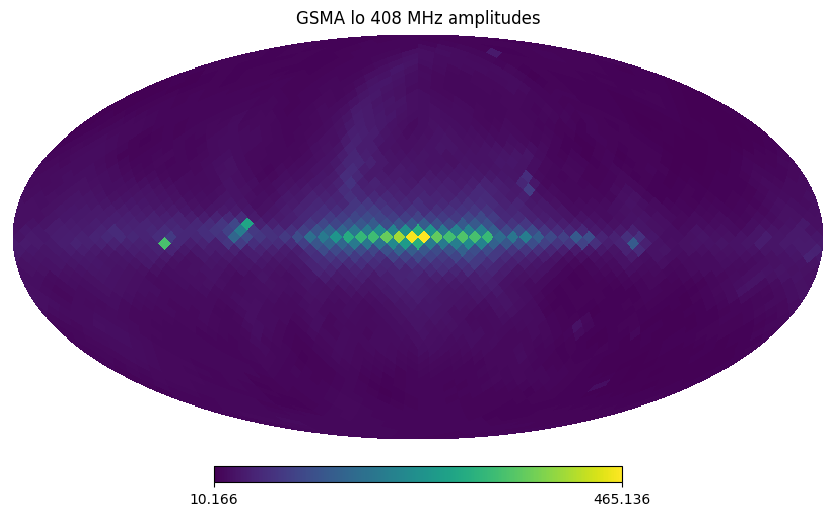

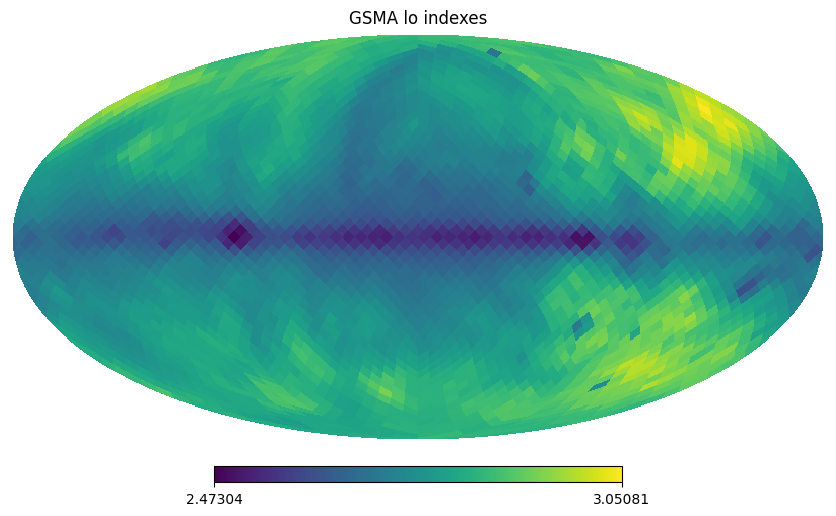

[2.46303511 2.61247858 2.76192205 2.91136552 3.06080899]
[[2.46303511 2.61247858]
 [2.61247858 2.76192205]
 [2.76192205 2.91136552]
 [2.91136552 3.06080899]]


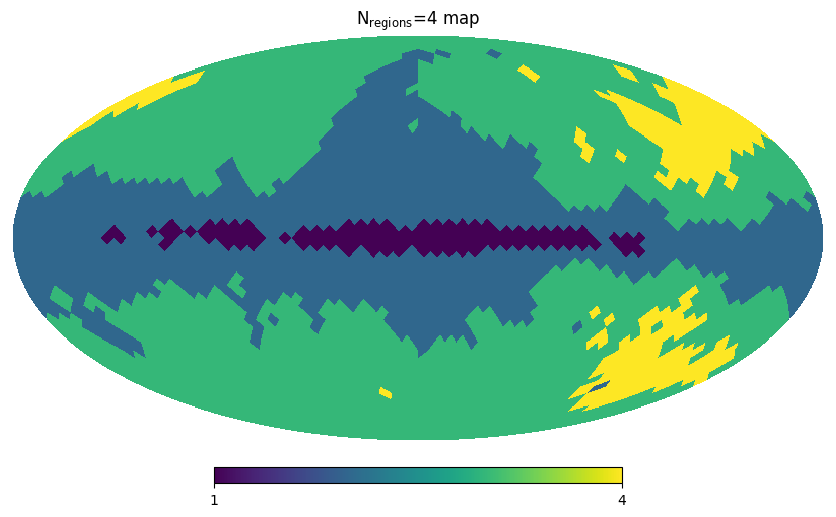

In [13]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 4
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()


In [14]:
model = FM.genopt_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

In [9]:
model(theta=np.array([1, 2, 3, 4]))

array([12149.05564687, 15134.6878158 , 18180.91829205, ...,
        1188.27559619,  1266.82865349,  1356.78497353])

In [6]:
def log_likelihood(theta, y, yerr, model):
    """
    Compute the Gaussian log-likelihood, given a model(theta) and data y
    with errors yerr.
    """
    y_model = model(theta)
    chi2 = (y - y_model)**2 / (yerr**2)
    return np.sum(-chi2 / 2)

def log_prior(theta, prior_range):
    """
    Log Prior probability

        log(prior(theta))

        This handles an unnormalised uniform prior
        within the rectangular bounds given by prior_range.

        inputs:
        theta - N array of parameter values
        prior_range - [N,2] array of prior ranges
        i.e. = [[lower1, upper1], ...]

        Returns 0 if theta in prior_range and -inf otherwise
    """

    lower =  theta > prior_range[:,0]
    upper = theta < prior_range[:,1]
    in_prior_range = all(lower & upper)

    #return prior value
    if in_prior_range:
        return 0.0
    return -np.inf

def log_posterior(theta, y, yerr, model, prior_range):
    lp = log_prior(theta, prior_range)
    if np.isfinite(lp):
        lp += log_likelihood(theta, y, yerr, model)
    return lp

In [10]:
import emcee
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))

# run emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
np.save("saves/chain_anstey4regions_gsmalo_speedy", sampler.get_chain())  # SAVE THE CHAIN.

  0%|          | 41/10000 [00:06<26:17,  6.31it/s]Traceback (most recent call last):
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/venv_mat/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_8944/1157229726.py", line 6, in log_likelihood
    y_model = model(theta)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py", line 211, in model
    p_fg = pix_forward_model_pl(powers=theta, nuarr=nuarr, base_map=base_map, masks=masks)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/nregions_models.py", line 34, in pix_forward_model_pl
    single_term = np.array(single_term).flatten()
KeyboardInterrupt
  0%|          | 41/10000 [00:06<26:33,  6.25it/s]


emcee: Exception while calling your likelihood function:
  params: [2.55289417 2.65435427 2.73864974 3.03800815]
  args: (array([6208.70213894, 5935.58121354, 5789.71578503, ..., 1263.09659239,
        959.12221218,  875.3949583 ]), array([0.05735411, 0.05483005, 0.05348296, ..., 0.01166799, 0.00885997,
       0.00808659]), <function generate_nregions_pl_forward_model.<locals>.model at 0x12cb09000>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

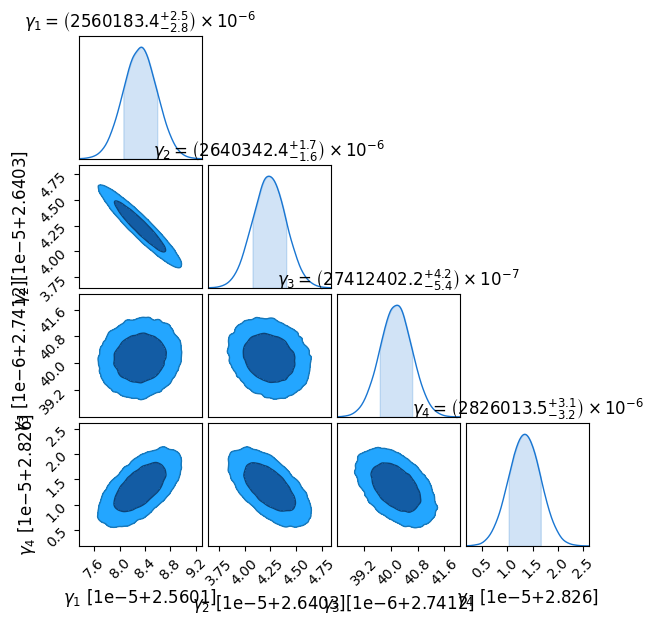

In [49]:
from chainconsumer import ChainConsumer
c=ChainConsumer()
chain = np.load("saves/chain_anstey4regions_gsmalo.npy")
chain = chain[1000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$'])
c.plotter.plot()
plt.show()

In [60]:
c.analysis.get_summary().values()

dict_values([[2.56018058929629, 2.560183402081722, 2.5601859168834644], [2.6403407815525215, 2.640342377382059, 2.6403440606543103], [2.741239674477335, 2.7412402185776723, 2.7412406372648115], [2.826010283416525, 2.826013460874419, 2.826016606820334]])

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_24116/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


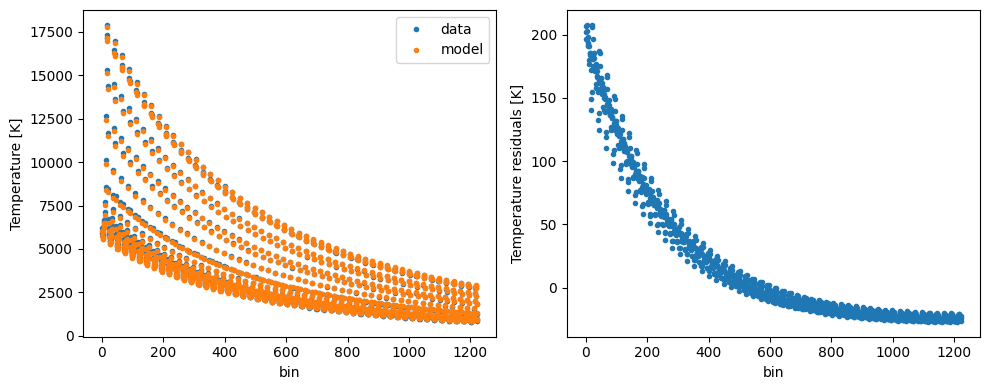

In [67]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



### Increase the number of regions to 6!

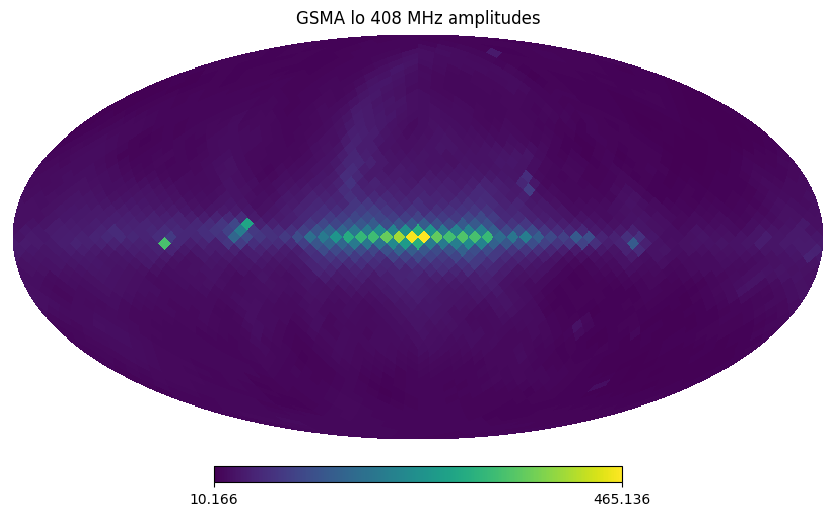

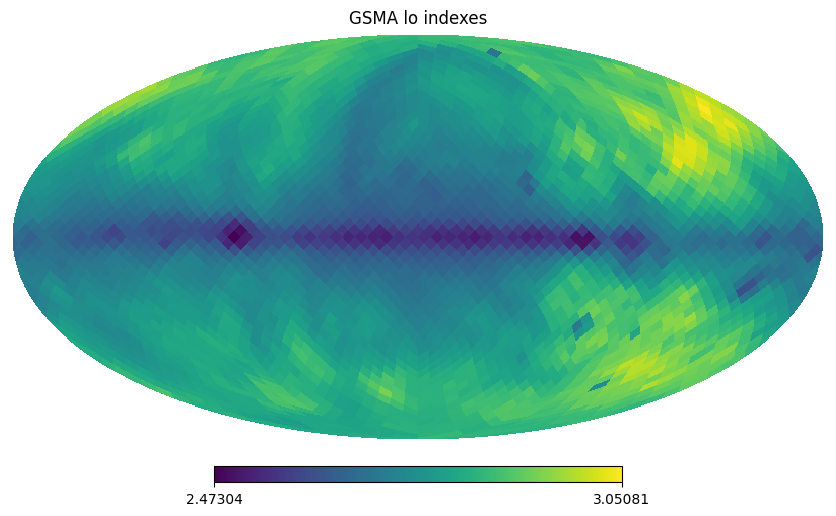

[2.46303511 2.56266409 2.66229307 2.76192205 2.86155103 2.96118001
 3.06080899]
[[2.46303511 2.56266409]
 [2.56266409 2.66229307]
 [2.66229307 2.76192205]
 [2.76192205 2.86155103]
 [2.86155103 2.96118001]
 [2.96118001 3.06080899]]


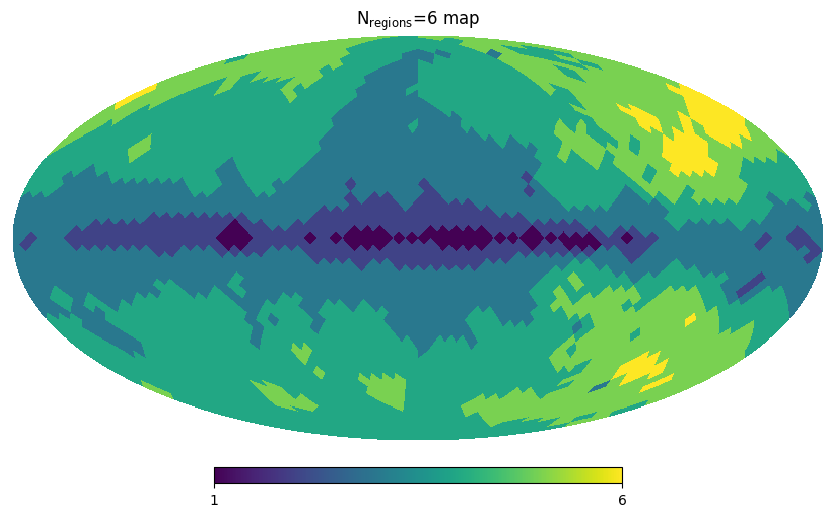

In [71]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 6
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()

# Set up the Nregions model.
model = FM.generate_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

# Run inference.
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))



In [82]:
np.mean(chain_flat, axis=0)

array([2.842971  , 2.28942074, 2.66266918, 2.73344628, 2.77715456,
       2.95407823])

In [72]:
# run emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
#np.save("saves/chain_anstey6regions_gsmalo", sampler.get_chain())  # SAVE THE CHAIN.

100%|██████████| 10000/10000 [26:11<00:00,  6.36it/s]


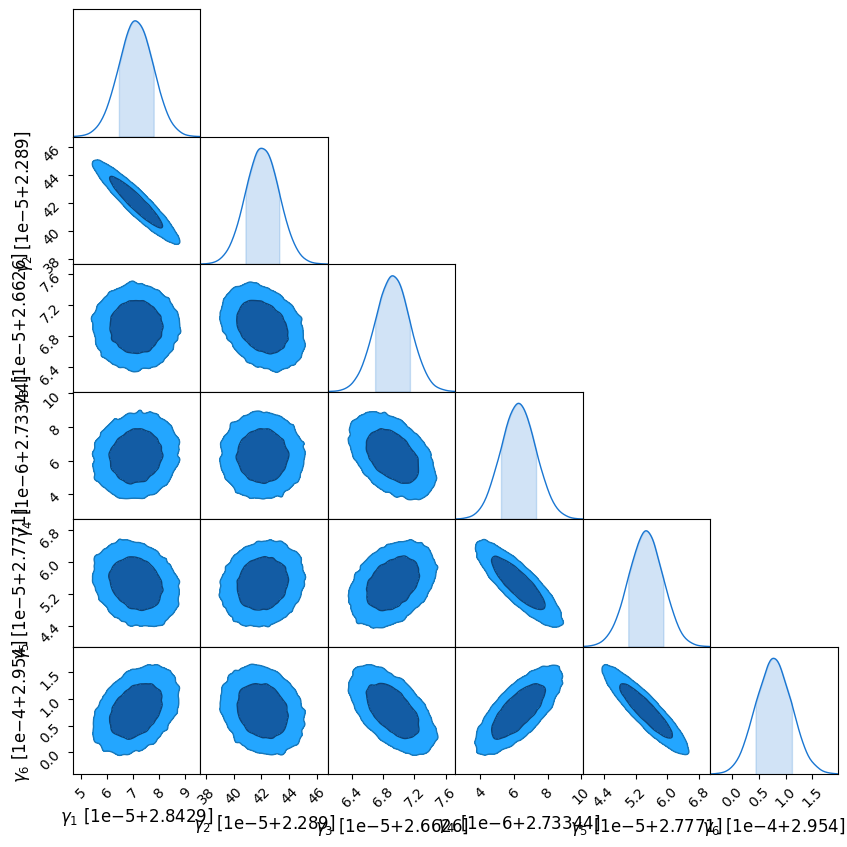

In [81]:
c=ChainConsumer()
chain = np.load("saves/chain_anstey6regions_gsmalo.npy")
chain = chain[2000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot()
plt.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_24116/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


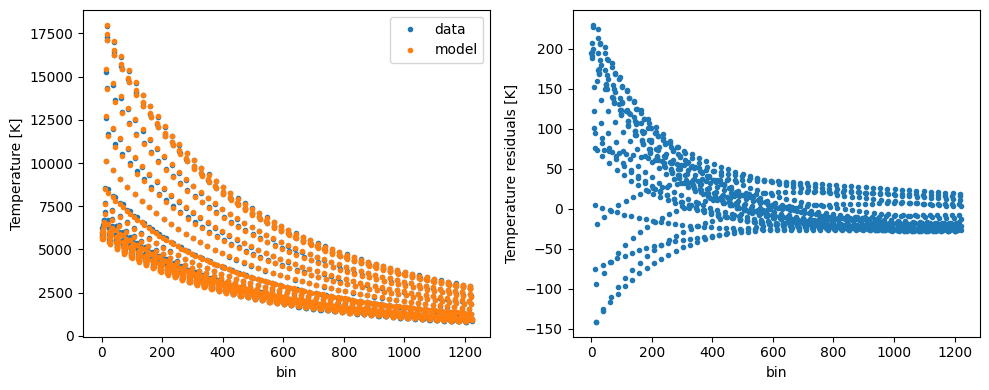

In [74]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



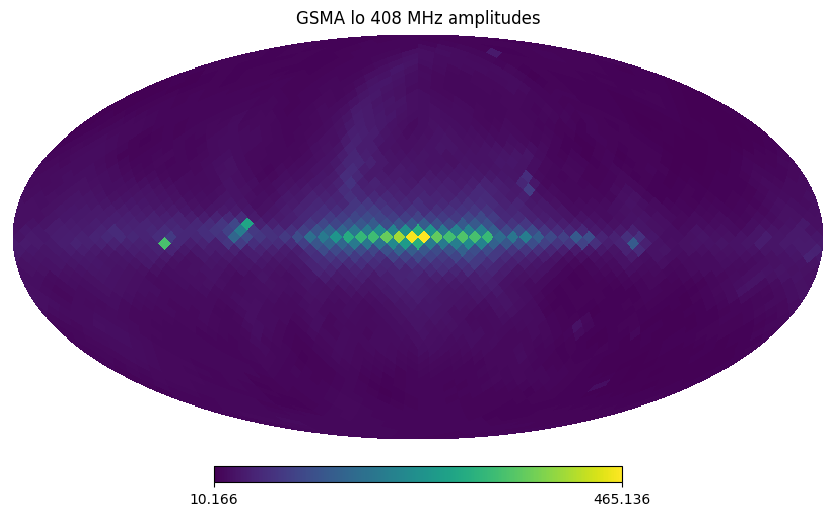

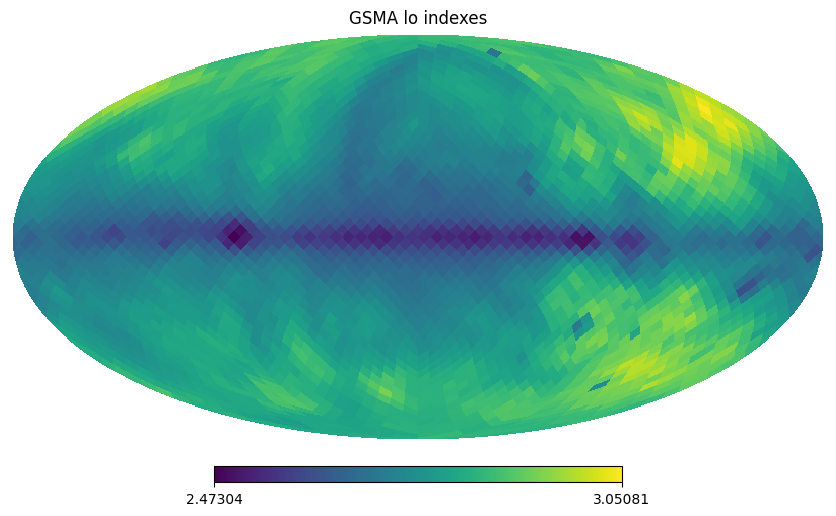

[2.46303511 2.52945443 2.59587375 2.66229307 2.72871239 2.79513171
 2.86155103 2.92797035 2.99438967 3.06080899]
[[2.46303511 2.52945443]
 [2.52945443 2.59587375]
 [2.59587375 2.66229307]
 [2.66229307 2.72871239]
 [2.72871239 2.79513171]
 [2.79513171 2.86155103]
 [2.86155103 2.92797035]
 [2.92797035 2.99438967]
 [2.99438967 3.06080899]]


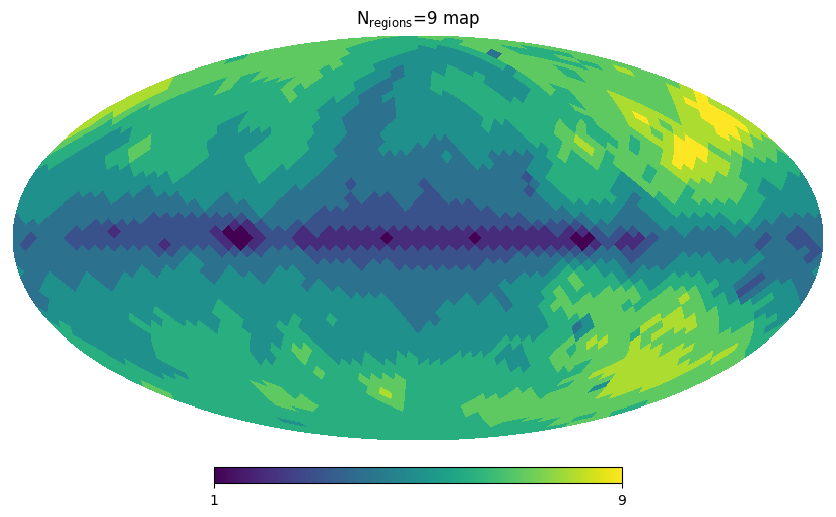

In [30]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 9
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()

# Set up the Nregions model.
model = FM.generate_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

# Run inference.
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))
prev_chain = np.load("saves/chain_anstey9regions_gsmalo2.npy")
theta_guess = prev_chain[-1]
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))



In [31]:
# run emcee
import emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
np.save("saves/chain_anstey9regions_gsmalo3", sampler.get_chain())  # SAVE THE CHAIN.

100%|██████████| 10000/10000 [2:13:23<00:00,  1.25it/s]    


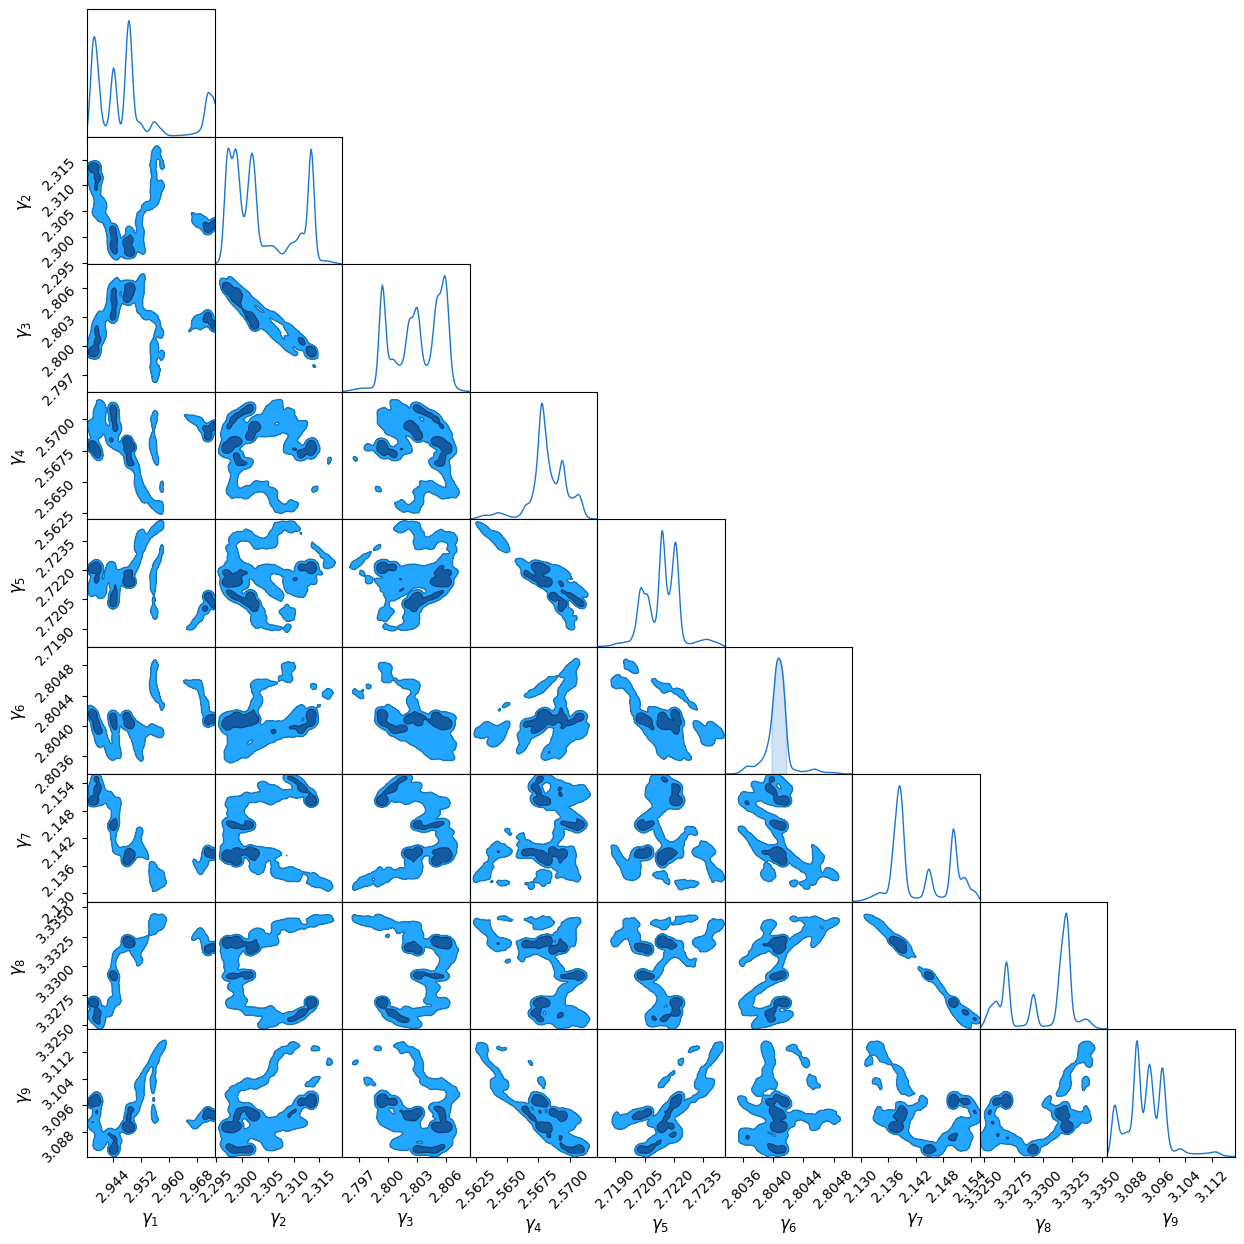

In [32]:
c=ChainConsumer()
chain = np.load("saves/chain_anstey9regions_gsmalo3.npy")
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$',r'$\gamma_8$',r'$\gamma_9$'])
c.plotter.plot()
plt.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_3141/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


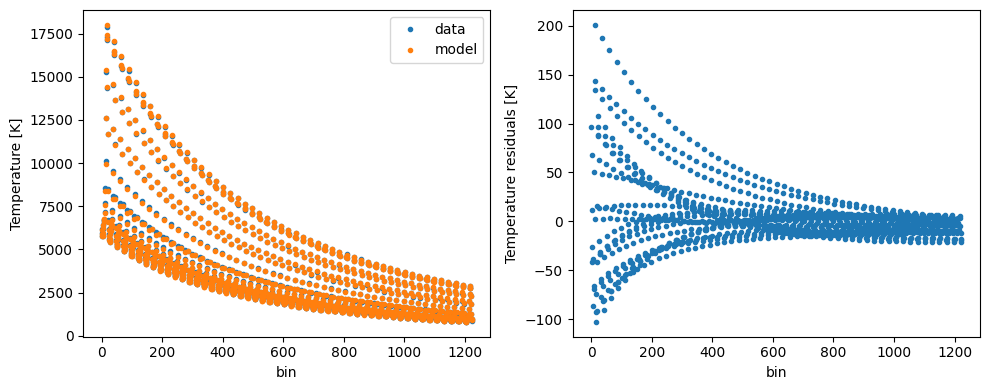

In [33]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



In [37]:
chain = np.load("saves/chain_anstey6regions_gsmalo_speedy.npy")


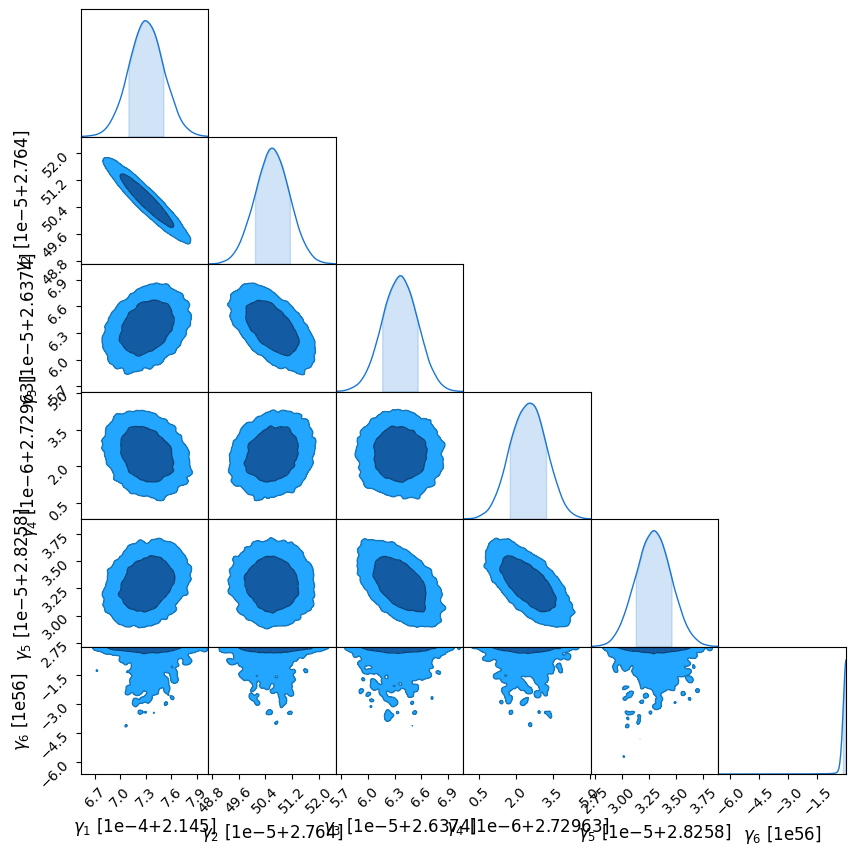

In [38]:
c=ChainConsumer()
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot()
plt.show()